In [120]:
# This is a test of the PyTorch library for neural networks

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## This notebook is the test of the PyTorch library for neural networks using the MSE Loss

In [121]:
# Loading in the MNIST dataset

# transforming pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# loading the data
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


In [122]:
print(len(training_data)) #The amount of samples in the dataset

#Note this is a tuple
#training_data[0]

#so we can access the label by 
image, label = training_data[0]  # Sample has 28x28 pixels
print(label) #this is the label for the data

image.shape #this is the shape of the image

60000
5


torch.Size([1, 28, 28])

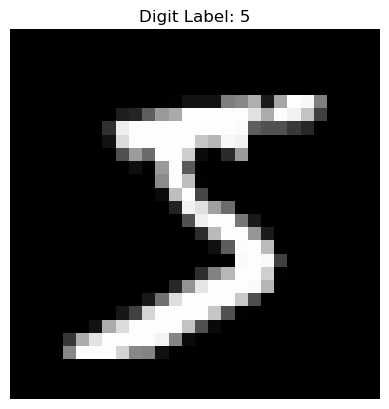

In [123]:
image, label = training_data[0]  # Sample has 28x28 pixels

# Display the image using matplotlib
plt.imshow(image.squeeze(), cmap='gray')  # Remove single channel with squeeze()
plt.title(f"Digit Label: {label}")
plt.axis('off')  # Turn off axis
plt.show()

### Batch Size: is the number of samples that we want to pass through the network at a time
### Epochs: is the number of times we want to pass through the entire dataset
### Learning Rate: is the step size for the gradient descent

In [124]:
# Note we are doing MLP (Multi Layer Perceptron) method and not CNN (Convolutional Neural Network)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            #28*28 is the number of features which is all of the pixels inside of an image and this will be done for each image
            nn.Linear(in_features=28*28, out_features=20), #outfeatures is the neurons in the next layer that we want to have.
            nn.ReLU(), #relu is the activation function
            nn.Linear(20, 10),
            nn.Softmax(dim=1) #softmax to get the probability of each class between 0 and 1
        )

    def forward(self, x):
        #take in all the x features and pass it through the layers with all the rows.
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [125]:
#Note we have training_data and test_data, we will drop the last batch as it will mess with the encoding dimensions.
train_dataloader = DataLoader(training_data, batch_size=64, drop_last=True)
test_dataloader = DataLoader(testing_data, batch_size=64, drop_last=True)


# #Dataloader is a way to load the data in batches
# for batch in train_dataloader:
#     print(batch) #batches are in size of 64

for batch in train_dataloader:
    images, labels = batch
    print(images.shape)  # e.g., torch.Size([64, 1, 28, 28])
    print(labels.shape)  # e.g., torch.Size([64])

    labels_one_hot = torch.zeros(labels.shape[0], 10)
    labels_one_hot.scatter_(1, labels.unsqueeze(1).long(), 1)
    print(labels_one_hot.shape)
    break





#[64, 1, 28, 28]
#28x28 is the width and height
# 1 is the channel
#64 is the batch size, so we converted the data into 64 sized batches

#remember we ave batches and label
len(train_dataloader) #938 * 64 = 60032 last batch has less than 64 938 batches

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])


937

## Notes:

- For batch sizes in tensors, they are the first dimension. When we grab the batch the X and y values will have the batch size as the first dimension.
- This is noted by when we do train_dataloader and set the batch size. After iterating through a value it has the shape of [64, 1, 28, 28] and [64]
- when we do one hot encoding technically we have a [64, 1] shape for the labels, but when we do torch.zeros(y.shape[0], 10) we are creating a tensor of shape [64, 10] where it may look like
-[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

In [147]:
class TrainingData(Dataset):
    def __init__(self):
        #using mean squared error loss function similar to prev implementation
        self.lossfn = nn.MSELoss()

    def gradient_descent(self, model, dataloader, optimizer):
        ''' we are minimizing the loss function for each batch
        model: the NN model that we used to make a prediction
        optimizer: the optimizer that we used to update the weights
        train_dataloader: the dataloader that we used to load the data

        '''
        size = len(dataloader)

        # Enumeration step gets the index of the current batch (X,y) X is the tenor containing the input feature ie image and y is the label.
        for batch, (X, y) in enumerate(dataloader):
            # Doing one hot encoding for the labels

            #creates a 0 tensor of shape batch size x 10
            y_one_hot = torch.zeros(y.shape[0], 10)
            y_one_hot.scatter_(1, y.unsqueeze(1).long(), 1)


            prediction = model.forward(X)

            # print(prediction.shape)
            loss = self.lossfn(prediction, y_one_hot)

            #Perform the backpropagation step for each layer in the model
            #Calculates all of the partial derivatives of the loss function with respect to the weights and biases
            loss.backward()

            optimizer.step()
            #prevents the gradient from accumulating
            optimizer.zero_grad()

            total = 1
            correct = 0
            #print(y.shape)
            _, predicted = torch.max(prediction.data, 1)
            #print(predicted.shape, "P")
            total += y.size(0)
            correct += (predicted == y).sum().item()

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                accuracy = 100 * correct / total
                print(f"loss: {loss:>7f}  [{current:>5d}/{size*64:>5d}]")
                print("accuracy: ", accuracy)

    def test_model(self, model, dataloader):
        '''
        model: the NN model that we used to make a prediction
        dataloader: the dataloader that we used to load the data
        '''
        model.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for X, y in dataloader:
                #one hot encoding the labels for the testing data
                y_one_hot = torch.zeros(y.shape[0], 10)
                y_one_hot.scatter_(1, y.unsqueeze(1).long(), 1)

                pred = model.forward(X)

                test_loss += self.lossfn(pred, y_one_hot).item()
                _, pred_indices = torch.max(pred.data, dim=1)
    
                correct += (pred_indices == y).type(torch.float).sum().item() 

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")




In [148]:
# Running the model and minizing the loss function using the gradient descent method with epochs
epochs = 10
learning_rate = 0.01

model = NeuralNetwork()
# loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
TrainingData = TrainingData()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    TrainingData.gradient_descent(model, train_dataloader, optimizer)

print("Done!")

Epoch 1
-------------------------------
loss: 0.090569  [    0/59968]
accuracy:  12.307692307692308
loss: 0.089877  [ 6400/59968]
accuracy:  20.0
loss: 0.089914  [12800/59968]
accuracy:  4.615384615384615
loss: 0.089765  [19200/59968]
accuracy:  20.0
loss: 0.090113  [25600/59968]
accuracy:  12.307692307692308
loss: 0.088821  [32000/59968]
accuracy:  21.53846153846154
loss: 0.086876  [38400/59968]
accuracy:  33.84615384615385
loss: 0.087718  [44800/59968]
accuracy:  32.30769230769231
loss: 0.087419  [51200/59968]
accuracy:  26.153846153846153
loss: 0.085743  [57600/59968]
accuracy:  35.38461538461539
Epoch 2
-------------------------------
loss: 0.086245  [    0/59968]
accuracy:  33.84615384615385
loss: 0.085642  [ 6400/59968]
accuracy:  35.38461538461539
loss: 0.086136  [12800/59968]
accuracy:  24.615384615384617
loss: 0.085241  [19200/59968]
accuracy:  23.076923076923077
loss: 0.086220  [25600/59968]
accuracy:  26.153846153846153
loss: 0.084120  [32000/59968]
accuracy:  33.84615384615

In [149]:
# Running model on testing data
TrainingData.test_model(model, test_dataloader)
print("Done!")


Test Error: 
 Accuracy: 40.8%, Avg loss: 0.080261 

Done!


## Summary of Tensors:
1. Batch dimension [61, 1, 28, 28] the first dimension is the batch size where 64 is the number of images in the batch.
2. 1 is the number of channels (greyscale or RGB)
3. 28 is the width of the image
4. 28 is the height of the image

- Labels in Pytorch are usually just [batch_size] where each entry is a single integer class ex 3 for digit 3

- Flattening is turning a multi-dimensional tensor into a 1D tensor. Only affecting the row and column dimensions. 
- One hot encoding is turning a 1D tensor into a 2D tensor where the first dimension is the batch size and the second dimension is the number of classes. Usually matched to the final layer of the neural network.

